In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc

import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt

from os import walk
from os.path import join

In [2]:
def get_files(data_path='data', exclude=['MATIC','sETH','frxETH']):
    files = []
    for (dirpath, dirnames, filenames) in walk(data_path):
        files.extend(filenames)
        break #only top directory
    
    for string in exclude:
        files = [f for f in files if string not in f]
    
    files = [f for f in files if '.csv' in f]

    return files

def get_df_from_file(file, data_path='data', eth_price=None, price_dfs=None, staking_data=None):

    def add_meta_data(split, df):
        df.filename = file
        df.fee_size = ''
        if split[6].isdigit():
            df.fee_size = split[6]    
        #    split.pop(-1)

        #if split[-1] in ['ng', 'concentrated']:
        #    split.pop(-1)

      #  df.name_token1, df.name_token0 = split[-1], split[-2]
        df.name_token1, df.name_token0 = split[4], split[5]
        df.chain, df.frequency  = split[3], split[2]

        df.amm = split[0]
       # if split[0] == 'uniswap':
        df.amm_version = split[1]

        titles = {'curve_daily_arbitrum_wstETH_ETH.csv':'wstETH - ETH (Curve v1; Arbitrum)',
                            'curve_daily_ethereum_cbETH_WETH.csv':'cbETH - WETH (Curve v2)',
                            'curve_daily_ethereum_rETH_WETH.csv':'rETH - WETH (Curve v2)',
                            'curve_daily_ethereum_stETH_ETH_ng.csv':'stETH - ETH (Curve v1; ng)',
                            'curve_daily_ethereum_stETH_ETH.csv':'stETH - ETH (Curve v1)',
                            'curve_daily_ethereum_stETH_WETH_concentrated.csv':'stETH - WETH (Curve v1; conc.)',
                            'curve_daily_ethereum_wstETH_rETH.csv':'wstETH - rETH (Curve v1)',
                            'curve_daily_optimism_wstETH_ETH.csv':'wstETH - ETH (Curve v1; Optimism)',
                            'uniswap_v3_daily_ethereum_cbETH_WETH_500_new.csv':'cbETH - WETH (Uniswap v3, 5bp)',
                            'uniswap_v3_daily_ethereum_rETH_WETH_500_new.csv':'rETH - WETH (Uniswap v3, 5bp)',
                            'uniswap_v3_daily_ethereum_WETH_sETH2_3000_new.csv':'WETH - sETH2 (Uniswap v3, 30bp)',
                            'uniswap_v3_daily_ethereum_wstETH_WETH_100_new.csv':'wstETH - WETH (Uniswap v3, 1bp)',
                            'uniswap_v3_daily_ethereum_wstETH_WETH_500_new.csv':'wstETH - WETH (Uniswap v3, 5bp)'
                            }

        titles = {
                    'uniswap_v3_daily_ethereum_cbETH_WETH_500_new.csv':'cbETH - WETH (Uniswap v3, 5bp)',
                    'uniswap_v3_daily_ethereum_rETH_WETH_500_new.csv':'rETH - WETH (Uniswap v3, 5bp)',
                    'uniswap_v3_daily_ethereum_WETH_sETH2_3000_new.csv':'WETH - sETH2 (Uniswap v3, 30bp)',
                    'uniswap_v3_daily_ethereum_wstETH_WETH_100_new.csv':'wstETH - WETH (Uniswap v3, 1bp)',
                    'uniswap_v3_daily_ethereum_wstETH_WETH_500_new.csv':'wstETH - WETH (Uniswap v3, 5bp)'
                    }
        
        df.title = titles[df.filename]

        return df

    df = pd.read_csv(join(data_path,file))
    df = df.apply(pd.to_numeric, errors='coerce')
    df['exact_date'] = pd.to_datetime(df['timestamp'],unit='s')
    df['date'] = df['exact_date'].dt.strftime('%Y-%m-%d')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').asfreq('D').reset_index()
    df.ffill(inplace=True)

    df = enrich_df(df, eth_price)
    df = enrich_df_with_daily_staking(df, staking_data)
    df = df.dropna().reset_index(drop=True)
    if 'token0Balance' in df.columns:
        df.rename(columns={'token0Balance': 'token0BalancePostion', 'token1Balance': 'token1BalancePostion'}, inplace=True)
    split = file.rstrip('.csv').split('_')
    df = add_meta_data(split, df)
    df = add_yahoo_price_data(df, price_dfs)

    split = file.rstrip('.csv').split('_')
    df = add_meta_data(split, df)
    df = truncate_dfs(df)
    df = df.dropna().reset_index(drop=True)
    

    split = file.rstrip('.csv').split('_')
    df = add_meta_data(split, df)
  

    return df


def enrich_df(df, eth_price, col='Close'):
    df = df.merge(eth_price[['date',col]], on='date', how='left')
    df = df.rename(columns={col: 'eth_price'})
    return df



def get_yahoo_price_data(files, data_path='price_data'):
    price_dfs = []
    for file in files:
        df = pd.read_csv(join(data_path,file))
        df['date'] = pd.to_datetime(df['Date'])
        df.name_token = file.rstrip('.csv').split('-')[0]
        price_dfs.append(df)
        
    return price_dfs
        
def add_yahoo_price_data(df, price_dfs, col='Close'):
    token0 = df.name_token0
    token1 = df.name_token1

    for p_df in price_dfs:
        #print(p_df.name_token)
        if token0.lower() == p_df.name_token.lower(): 
            df = df.merge(p_df[['date',col]], on='date', how='left')
            df = df.rename(columns={col: 'token0_yahoo_price'})
        if token1.lower() == p_df.name_token.lower():
            df = df.merge(p_df[['date',col]], on='date', how='left')
            df = df.rename(columns={col: 'token1_yahoo_price'})
    return df


def get_staking_data(file, data_path='staking_data'):
    df = pd.read_csv(join('staking_data', staking_file), sep=';')
    df['date'] = pd.to_datetime(df['Date'],format='%d.%m.%Y')
    df = df.rename(columns={'ETH staking % per day': 'daily_staking_rate'})
    return df

def enrich_df_with_daily_staking(df, staking_data_data):
    df = df.merge(staking_data[['date','daily_staking_rate']], on='date', how='left')
    return df


def truncate_dfs(df):

    to_be_truncated= {'uniswap_v3_daily_ethereum_wstETH_WETH_100.csv': dt.date(2023,6,1),
                      'uniswap_v3_daily_ethereum_cbETH_WETH_500.csv': dt.date(2022,10,1),
                      'uniswap_v3_daily_ethereum_wstETH_WETH_500.csv': dt.date(2022,4,1),
                      'uniswap_v3_daily_arbitrum_wstETH_WETH_100.csv': dt.date(2023,6,1)}
    

    if df.filename in to_be_truncated.keys():
        df = df[df['date']>pd.to_datetime(to_be_truncated[df.filename])]
    return df


In [3]:
def calculate_stats(df):

    #if df.amm == 'curve':
    rebase_value = 0.05
    a = np.full((len(df),), (1+rebase_value)**(1/365))
    a[0]=1
    df['rebase_adjustment']=a
    df['rebase_adjustment']=df['rebase_adjustment'].cumprod()

    df['staking_daily']=df['rebase_adjustment']-1
    df['staking_rate'] = df['rebase_adjustment']

    df['daily_staking_rate'][0]=0
    df['staking_cumprod']=(1+df['daily_staking_rate']).cumprod()


    lsd = 'token0'
    weth = 'token1'
    if df.name_token0=="WETH" or df.name_token0=="ETH" :
        lsd = 'token1'
        weth = 'token0'
        
    
    df[lsd+'_position_value']= df[lsd+'BalancePostion']*df[lsd+'_yahoo_price']
    df[weth+'_position_value']= df[weth+'BalancePostion']*df[weth+'_yahoo_price']


    df[lsd+'hodl_position_value']= df[lsd+'BalancePostion'][0]*df[lsd+'_yahoo_price']
    df[weth+'hodl_position_value']= df[weth+'BalancePostion'][0]*df[weth+'_yahoo_price']

   # if df.name_token0=="sETH" or df.name_token0=="sETH" :
   #     df[lsd+'hodl_position_value'] = df[lsd+'hodl_position_value'] * df['staking_cumprod']
   #     df[lsd+'_position_value'] =  df[lsd+'_position_value'] * df['staking_cumprod']

    df['hodl']=df[weth+'hodl_position_value'] + df[lsd+'hodl_position_value']#*df['rebase_adjustment']
    df['hodl']=df['hodl']/df['eth_price']
    df['hodl_normalized'] = df['hodl']/df['hodl'][0]


    #df['tvl'] = df[weth+'BalancePostion']*df[weth+'_yahoo_price'] + df[lsd+'BalancePostion']*df[lsd+'_yahoo_price']
    df['tvl'] = df['totalValueLockedUSD']
    df['tvl_ethnorm'] = df['tvl']/df['eth_price']

    df['lp_value']=df['positionValueETH']/df['positionValueETH'][0]
    #len_df = len(df)
    #df['lp_value'] = np.full(len_df,1)
    #for n in range(len_df) :
    #    if n > 0 :
    #        df['lp_value'][n] = df['lp_value'][n-1]*(1+df['dailyLPFeeROIAverage'][n])


    #print(df.filename)

    return df






In [4]:
files = get_files()

price_files = get_files(data_path='price_data')
yahoo_data = get_yahoo_price_data(price_files)

staking_file = get_files(data_path='staking_data')[0]
staking_data = get_staking_data(staking_file)


In [5]:
eth_price = pd.read_csv('price_data/ETH-USD.csv')
eth_price['date'] = pd.to_datetime(eth_price['Date'])

dfs = [get_df_from_file(f, eth_price=eth_price, price_dfs=yahoo_data, staking_data=staking_data) for f in files]
dfs = sorted(dfs, key = lambda x: (x.amm, x.name_token0))


In [6]:

#for df in dfs:
#    print(df.columns)


dfs = [calculate_stats(df) for df in dfs]

#file0 = dfs[0]
#calculate_stats(dfs[0])
#calculate_stats(dfs[1])



uniswap_v3_daily_ethereum_cbETH_WETH_500_new.csv
uniswap_v3_daily_ethereum_wstETH_WETH_100_new.csv
uniswap_v3_daily_ethereum_rETH_WETH_500_new.csv
uniswap_v3_daily_ethereum_wstETH_WETH_500_new.csv


/var/folders/y_/27jchs_x56gfpv07wkchjxj40000gn/T/ipykernel_1396/596766714.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['daily_staking_rate'][0]=0
/var/folders/y_/27jchs_x56gfpv07wkchjxj40000gn/T/ipykernel_1396/596766714.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['daily_staking_rate'][0]=0
/var/folders/y_/27jchs_x56gfpv07wkchjxj40000gn/T/ipykernel_1396/596766714.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:


import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc

import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt

plt.style.use('https://raw.githubusercontent.com/garrettj403/SciencePlots/master/scienceplots/styles/science.mplstyle')

def add_events_to_ax(ax, color='darkgrey'):
    def draw_event(date, text, ax=ax, fontsize='medium', color='darkgrey'):
        terra = ax.axvline(date, 0,0.8, color=color, lw = 1)
        trans = ax.transData.transform(terra.get_xydata())
        trans = ax.transAxes.inverted().transform(trans)
        terra_text = ax.text(trans[1][0]+0.01,0.05,
                s=text,fontsize=fontsize,color=color,
                rotation=90, transform=ax.transAxes)
    
    events = [(dt.datetime(2022, 5, 7), 'Terra Collapse'),
              (dt.datetime(2022, 11, 2), 'FTX Collapse'),
              (dt.datetime(2022, 9, 15), 'The Merge'),
              (dt.datetime(2023, 4, 12), 'Shanghai Upgrade')
              ]
    
    for event in events:
        date, text = event
        draw_event(date, text, color=color)

plt.rc('axes', titlesize='small')
plt.rc('axes', labelsize='small')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

TypeError: 'NoneType' object is not subscriptable

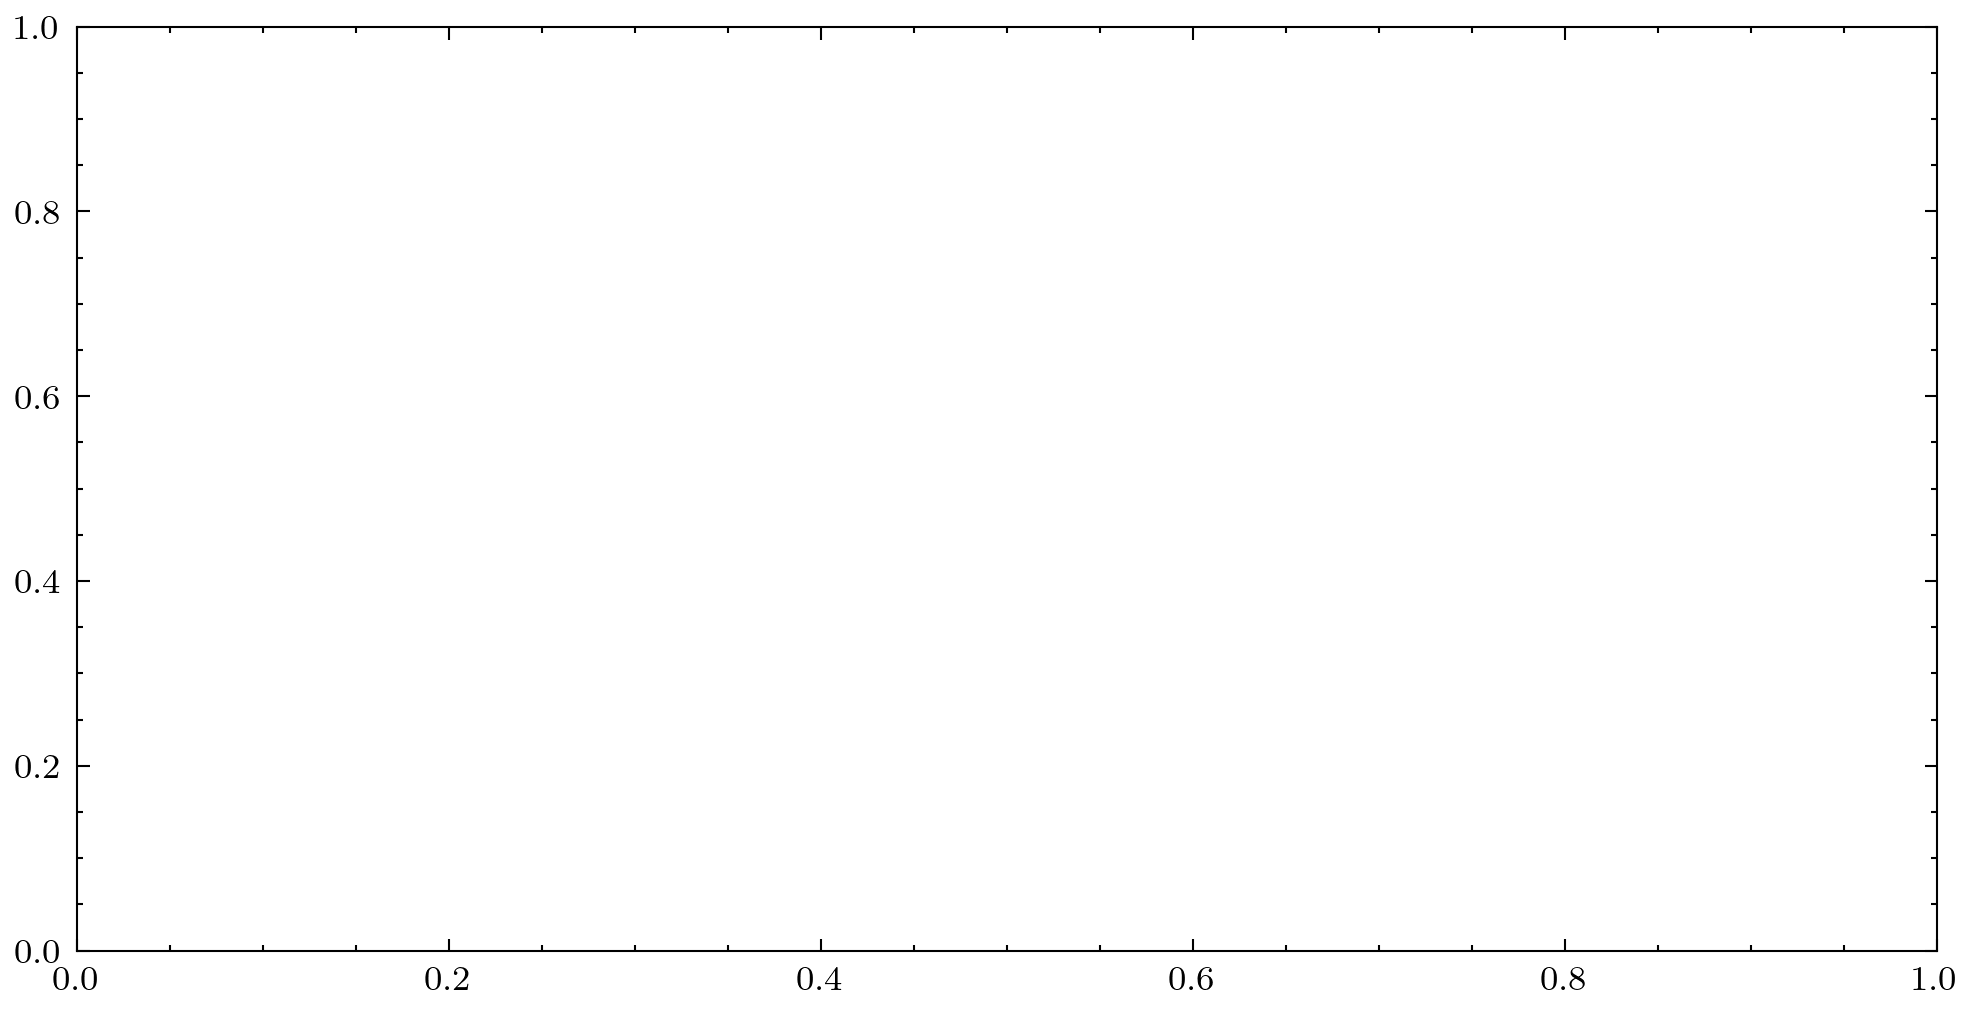

In [8]:
df = next((x for x in dfs if x.filename == 'curve_daily_ethereum_stETH_ETH.csv'), None)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,4),dpi =300)

ws_size = 7

ax.plot(df['date'], df['staking_cumprod'].pct_change().rolling(ws_size).mean(), color='red', label='Staking Return')

y = (df['lp_value'].pct_change()-df['hodl_normalized'].pct_change()).rolling(ws_size).mean()
ax.plot(df['date'], y, label = 'LP Excess Return (moving average {} days)'.format(ws_size))


ax.axhline(0, color='k', ls = '--')


s = y - df['staking_cumprod'].pct_change().rolling(ws_size).mean()


ax.fill_between(df['date'],-10, 10, where=(y >0) & (s<0), color='yellow', alpha=0.2, lw = 0, interpolate=True)
ax.fill_between(df['date'],-10, 10, where=y <0, color='red', alpha=0.2, lw=0, interpolate=True)
ax.fill_between(df['date'],-10, 10, where=s >0, color='green', alpha=0.2, lw = 0, interpolate=True)

#ax.set_ylim(-10,10)
y1 = np.nanmax(df['staking_cumprod'].pct_change().rolling(ws_size).mean())
y2 = np.nanmax(y)

ax.set_xlim(min(df['date'][ws_size:]),max(df['date']))
ax.set_ylim(np.nanmin(y)-0.05, max([y1,y2])+0.05)

#plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
# Create list of monthly ticks made of timestamp objects
monthly_ticks = [timestamp for idx, timestamp in enumerate(df.date[ws_size:])
                if (idx==0) or (timestamp.month != df['date'][ws_size+idx-1].month)]

# Select appropriate number of ticks and include last month
step = 1
while len(monthly_ticks[::step]) > 10:
    step += 1
ticks = np.unique(np.append(monthly_ticks[::step], monthly_ticks[-1]))

# Create tick labels from tick timestamps
labels = [timestamp.strftime('%b\n%Y') if (timestamp.year != ticks[idx-1].year) or (idx==0)
        else timestamp.strftime('%b') for idx, timestamp in enumerate(ticks)]

ax.set_xticks(ticks, labels, rotation=0, ha='center', fontsize = 'small')
ax.set_ylabel('LP Excess Return')

ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_title(df.title)
add_events_to_ax(ax, color =  'k')
#vals = ax.get_yticks()
#ax.set_yticklabels(['{:,.0}bp'.format(x*100) for x in vals])


legend = ax.legend(facecolor='white', framealpha=1)


plt.savefig("stETH_ETHcurve_MA_{}.pdf".format(ws_size), facecolor=fig.get_facecolor())


In [ ]:
df = next((x for x in dfs if x.filename == 'curve_daily_ethereum_stETH_ETH.csv'), None)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,4),dpi =300)

ax.plot(df['date'], df['staking_cumprod'], color='red', label='Stake')
ax.plot(df['date'], df['hodl_normalized'], color = 'orange', label='HODL')
ax.plot(df['date'], df['lp_value'], label='LP')

ax.set_xlim(min(df.date), max(df.date))

        
#plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
# Create list of monthly ticks made of timestamp objects
monthly_ticks = [timestamp for idx, timestamp in enumerate(df.date)
                if (idx==0) or (timestamp.month != df['date'][idx-1].month)]

# Select appropriate number of ticks and include last month
step = 1
while len(monthly_ticks[::step]) > 10:
    step += 1
ticks = np.unique(np.append(monthly_ticks[::step], monthly_ticks[-1]))

# Create tick labels from tick timestamps
labels = [timestamp.strftime('%b\n%Y') if (timestamp.year != ticks[idx-1].year) or (idx==0)
        else timestamp.strftime('%b') for idx, timestamp in enumerate(ticks)]

ax.set_xticks(ticks, labels, rotation=0, ha='center', fontsize = 'small')
ax.set_ylabel('Portfolio Value (ETH)')

ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_title(df.title)
add_events_to_ax(ax, color = 'k')
ax.set_ylim(0.5)
#vals = ax.get_yticks()
#ax.set_yticklabels(['{:,.0}bp'.format(x*100) for x in vals])

legend = ax.legend(loc=2)



plt.savefig("stETH_ETHcurve_stragegies.pdf", facecolor=fig.get_facecolor())

In [ ]:
fig, axes = plt.subplots(nrows=4,ncols=3, figsize=(20,10),dpi =300)
formatter = mdates.DateFormatter("%Y%m") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels




i = 0 
for c in axes:
    for ax in c:
        if i < len(dfs):
            df = dfs[i]

            ax.plot(df['date'], df['staking_cumprod'], color='red', label='Stake')
            ax.plot(df['date'], df['hodl_normalized'], color = 'orange', label='HODL')
            ax.plot(df['date'], df['lp_value'], label='LP')

            ax.set_xlim(min(df.date), max(df.date))

            #plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
            # Create list of monthly ticks made of timestamp objects
            monthly_ticks = [timestamp for idx, timestamp in enumerate(df.date)
                            if (idx==0) or (timestamp.month != df['date'][idx-1].month)]

            # Select appropriate number of ticks and include last month
            step = 1
            while len(monthly_ticks[::step]) > 10:
                step += 1
            ticks = np.unique(np.append(monthly_ticks[::step], monthly_ticks[-1]))

            # Create tick labels from tick timestamps
            labels = [timestamp.strftime('%b\n%Y') if (timestamp.year != ticks[idx-1].year) or (idx==0)
                    else timestamp.strftime('%b') for idx, timestamp in enumerate(ticks)]
        
            ax.set_xticks(ticks, labels, rotation=0, ha='center', fontsize = 'small')
            ax.set_ylabel('Portfolio Value (ETH)')
            
            ax.tick_params(axis='x', which='minor', bottom=False)
            ax.set_title(df.title)

            #vals = ax.get_yticks()
            #ax.set_yticklabels(['{:,.0}bp'.format(x*100) for x in vals])

            if i == 0:
                legend = ax.legend()

        i +=1

#ax.set_title(df.filename)
#ax.set_ylabel('Price')
fig.set_facecolor('w')
print("h0")
fig.tight_layout()
print("h1")
plt.savefig('portfolio_value.pdf')
print("h2")

In [ ]:
fig, axes = plt.subplots(nrows=4,ncols=3, figsize=(20,10),dpi =300)

formatter = mdates.DateFormatter("%Y%m") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels



#use both windows ie. 7 & 30

i = 0 
for c in axes:
    for ax in c:
        if i < len(dfs):
            df = dfs[i]
            ws_size = 7

            ax.plot(df['date'], df['staking_cumprod'].pct_change().rolling(ws_size).mean(), color='red', label='Staking Return')

            y = (df['lp_value'].pct_change()-df['hodl_normalized'].pct_change()).rolling(ws_size).mean()
            ax.plot(df['date'], y, label = 'LP Excess Return (moving average {} days)'.format(ws_size))


            ax.axhline(0, color='k', ls = '--')


            s = y - df['staking_cumprod'].pct_change().rolling(ws_size).mean()


            ax.fill_between(df['date'],-10, 10, where=(y >0) & (s<0), color='yellow', alpha=0.2, lw = 0, interpolate=True)
            ax.fill_between(df['date'],-10, 10, where=y <0, color='red', alpha=0.2, lw=0, interpolate=True)
            ax.fill_between(df['date'],-10, 10, where=s >0, color='green', alpha=0.2, lw = 0, interpolate=True)
            
            #ax.set_ylim(-10,10)
            y1 = np.nanmax(df['staking_cumprod'].pct_change().rolling(ws_size).mean())
            y2 = np.nanmax(y)

            ax.set_xlim(min(df['date'][ws_size:]),max(df['date']))
            ax.set_ylim(np.nanmin(y)-0.0001, max([y1,y2])+0.0001)
        
            #plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
            # Create list of monthly ticks made of timestamp objects
            monthly_ticks = [timestamp for idx, timestamp in enumerate(df.date[ws_size:])
                            if (idx==0) or (timestamp.month != df['date'][ws_size+idx-1].month)]

            # Select appropriate number of ticks and include last month
            step = 1
            while len(monthly_ticks[::step]) > 10:
                step += 1
            ticks = np.unique(np.append(monthly_ticks[::step], monthly_ticks[-1]))

            # Create tick labels from tick timestamps
            labels = [timestamp.strftime('%b\n%Y') if (timestamp.year != ticks[idx-1].year) or (idx==0)
                    else timestamp.strftime('%b') for idx, timestamp in enumerate(ticks)]
        
            ax.set_xticks(ticks, labels, rotation=0, ha='center', fontsize = 'small')
            ax.set_ylabel('LP Excess Return')
            
            ax.tick_params(axis='x', which='minor', bottom=False)
            ax.set_title(df.title)

            #vals = ax.get_yticks()
            #ax.set_yticklabels(['{:,.0}bp'.format(x*100) for x in vals])

            if i == 0:
                legend = ax.legend(facecolor='white', framealpha=1)
                

        i +=1

fig.set_facecolor('w')
fig.tight_layout()
plt.savefig('LP_excess_return_MA_{}.pdf'.format(ws_size))

In [ ]:
fig, axes = plt.subplots(nrows=4,ncols=3, figsize=(20,10),dpi =300)
formatter = mdates.DateFormatter("%Y%m") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels



i = 0
for c in axes:
    for ax in c:
        if i < len(dfs):
            df=dfs[i]
            ax2 = ax.twinx()
            ax2.bar(dfs[i]['date'], dfs[i]['dailyVolumeUSD']/dfs[i]['eth_price'], color='orange',alpha=0.8, label='Volume')

            ax.plot(dfs[i]['date'], dfs[i]['tvl']/dfs[i]['eth_price'], color='blue', label='Total Value Locked (TVL)')
            ax.fill_between(dfs[i]['date'],0, dfs[i]['tvl']/dfs[i]['eth_price'], color='blue', alpha=0.2)
            
            ax.set_xlim(min(df.date), max(df.date))
            ax.set_ylim(0)
            ax2.set_ylim(0)
        
            #plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
            # Create list of monthly ticks made of timestamp objects
            monthly_ticks = [timestamp for idx, timestamp in enumerate(df.date)
                            if (idx==0) or (timestamp.month != df['date'][idx-1].month)]

            # Select appropriate number of ticks and include last month
            step = 1
            while len(monthly_ticks[::step]) > 10:
                step += 1
            ticks = np.unique(np.append(monthly_ticks[::step], monthly_ticks[-1]))

            # Create tick labels from tick timestamps
            labels = [timestamp.strftime('%b\n%Y') if (timestamp.year != ticks[idx-1].year) or (idx==0)
                    else timestamp.strftime('%b') for idx, timestamp in enumerate(ticks)]
        
            ax.set_xticks(ticks, labels, rotation=0, ha='center', fontsize = 'small')
            ax.set_ylabel('Total Value Locked (ETH)')
            ax2.set_ylabel('Volume (ETH)')
            
            ax.tick_params(axis='x', which='minor', bottom=False)
            ax.set_title(df.title)

            if i == 0:
                ax.legend(loc=2)
                ax2.legend(loc=1)


        i +=1

#ax.set_title(df.filename)
#ax.set_ylabel('Price')
#fig.autofmt_xdate()
fig.set_facecolor('w')
fig.tight_layout()
plt.savefig('TVL_Volume.pdf')

In [ ]:
fig, axes = plt.subplots(nrows=4,ncols=3, figsize=(20,10),dpi =300)

formatter = mdates.DateFormatter("%Y%m") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels




i = 0 
for c in axes:
    for ax in c:
        if i < len(dfs):
            ax.bar(dfs[i]['date'], dfs[i]['dailyVolumeUSD']/dfs[i]['eth_price'], color='red', label='Staking')
            string = dfs[i].amm + ': ' + dfs[i].name_token0 +' vs. '+ dfs[i].name_token1
            if dfs[i].amm == 'uniswap':
                string += ' '+dfs[i].fee_size

            string = dfs[i].filename
            ax.set_title(string)


        i +=1

#ax.set_title(df.filename)
#ax.set_ylabel('Price')

fig.set_facecolor('w')
fig.tight_layout()

In [ ]:
tvl_frames = []
for df in dfs:
    d = df[['date','tvl_ethnorm']]
    d.name = df.filename
    d = d.rename(columns={'tvl_ethnorm':  df.filename})
    d = d.set_index('date')
    tvl_frames.append(d)

df = tvl_frames[0]
for d in tvl_frames:
    df=pd.merge(df,d, how='outer', left_index=True, right_index=True)

for c in df.columns:
    if np.isnan(df[c][0]):
        df[c][0]=0
    #df = df.set_index('Datetime')
    #df = df.rename(columns={col: 'token1_yahoo_price'})

df.ffill(inplace=True)


stack = np.vstack([df[c] for c in df.columns])
labels = [c for c in df.columns]

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5),dpi =300)


import matplotlib as mpl

cmap = plt.get_cmap('jet', stack.shape[0])
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]


ax.stackplot(df.index, stack, labels = labels[1:3], colors=custom_palette)
#/////add_events_to_ax(ax)
ax.legend()

#ax.set_title(df.filename)
#ax.set_ylabel('Price')
fig.set_facecolor('w')
fig.tight_layout()

'uniswap_v3_daily_ethereum_wstETH_WETH_100.csv' - ab 06/2023

In [ ]:
df = next((x for x in dfs if x.filename == 'uniswap_v3_daily_arbitrum_wstETH_WETH_100.csv'), None)
#df = dfs[1]


fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,4),dpi =300)

ws_size = 31

ax.plot(df['date'], df['staking_cumprod'], color='lightgrey', label='Staking')

ax.plot(df['date'], df['hodl_normalized'], label = 'HODL')
ax.plot(df['date'], df['lp_value'], label = 'LP')


ax.plot(df['date'], df['dailyVolumeUSD'], label = 'Vol')
#add_events_to_ax(ax)

ax.legend()
ax.set_title(df.filename)
ax.set_ylabel('Postition Value')

fig.set_facecolor('w')
fig.tight_layout()

#plt.savefig("LST_ETH.svg", facecolor=fig.get_facecolor())
#add rebasing to some tokens 
#add staking